# Brownian Motion on Hyperspheres

I'm mainly interested in the expected distance from the starting point (in the embedding space) after $n$ steps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import uniform

import torch as t

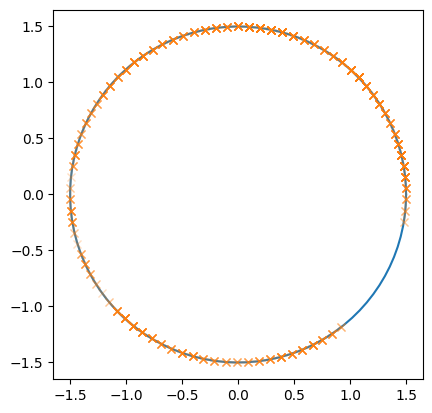

tensor([0.0000, 0.0010, 0.0014,  ..., 0.2988, 0.2988, 0.2989])

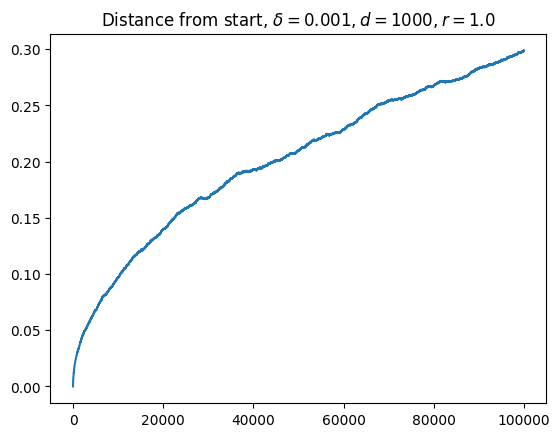

In [53]:
# Warm-up: simulating Brownian motion on S^1

def apply_householder_matrix_from_vertical_(x: t.Tensor, vs: t.Tensor):
    """Applies the above for the case that y = (0, ..., 0, 1)   
    without having to compute the matrix explicitly.

    The Householder matrix maps a vector |x> onto |y>

    First, you normalize both vectors.
    
    Then you define |c> = |x> + |y>

    Then you define the Householder matrix:
    
    H = 2 |c><c| / (<c|c>) - I

    That is:

    H|v> = 2 |c><c|v> / <c|c> - |v>

    Parameters
    ----------
    x : t.Tensor shape (d,)    
        Vector which defines the rotation. This is where (0, ..., 0, 1) is mapped.
    vs : t.Tensor shape (n, d)
        n Vectors to rotate

    """
    x_norm = t.norm(x)
    x /= x_norm
    x[-1] += 1
    
    vs -= (2 * t.inner(x, vs).view(-1, 1) / t.dot(x, x)) * x.view(1, -1)
    x[-1] -= 1
    x *= x_norm

def sample_from_hypersphere_intersection(
    r: t.Tensor,
    epsilon: float,
    n_samples: int,
):
    """Sample points from the intersection of two hyperspheres.

    Parameters
    ----------
    r : t.Tensor
        Vector that determines the radius of the larger hypersphere
    epsilon : float
        Radius of the smaller hypersphere, centered at r
    n_samples : int
        Number of samples to take

    Returns
    -------
    t.Tensor
        Array of shape (n_samples, r.shape[0])
    """

    d = r.shape[0]
    r_norm = t.norm(r)

    # Get the angle of the cone which goes through the center of the sphere and the intersection
    cone_angle = t.arccos(1 - epsilon**2 / (2 * r_norm**2))

    # Get the perp distance from r to the intersection
    epsilon_inner = r_norm * t.sin(cone_angle)

    # Sample a perturbation from the d-1 dimensional hypersphere of intersection
    perturbations = t.empty(n_samples, d)
    t.nn.init.normal_(perturbations)
    perturbations *= epsilon_inner / t.norm(perturbations[:, :-1], dim=1, keepdim=True)
    perturbations[:, -1] = 0

    # Apply the rotation 
    apply_householder_matrix_from_vertical_(r, perturbations)

    # Shift the perturbations
    perturbations += r * t.cos(cone_angle)

    return perturbations

def brownian_motion(n, d=2, delta=0.001, mu=0, sigma=1, r=1.):
    # Simulate Brownian motion on S^1
    # n: number of steps
    # dt: time step
    # x0: initial position
    # mu: drift
    # sigma: diffusion
    # Returns: array of positions
    
    x = t.zeros((n, d))
    x[0, -1] = r

    for i in range(1, n):
        x[i, :] = sample_from_hypersphere_intersection(x[i-1, :], delta, 1)[0]
    
    return x

def plot_brownian_motion(n, d=2, delta=0.1, mu=0, sigma=1, r=1.):
    x = brownian_motion(n, d, delta, mu, sigma, r)

    # Plot the circle
    theta = np.linspace(0, 2 * np.pi, 100)
    plt.plot(r * np.cos(theta), r * np.sin(theta))

    # Plot the path
    plt.plot(x[:, 0], x[:, 1], '-x', alpha=0.25)

    # Make it square
    plt.axis('square')
    plt.show()

plot_brownian_motion(1000, r=1.5)

def plot_distance_from_start(n, d=2, delta=0.1, mu=0, sigma=1, r=1., window=1):
    x0 = t.zeros(d)
    x0[-1] = r

    x = brownian_motion(n, d, delta, mu, sigma, r)
    norms = t.norm(x - x0, dim=1)

    # Window the norms
    norms = t.conv1d(norms.view(1, 1, -1), t.ones(1, 1, window), padding=window // 2).view(-1)  / window 

    # Plot the average as a horizontal line
    # overall_mean = norms[1000:].mean()
    # plt.axhline(overall_mean, color='red', alpha=0.5)
    # print(overall_mean)

    plt.title(f"Distance from start, $\\delta={delta}, d={d}, r={r}$")
    plt.plot(norms, label=r"$z(\theta)$")

    return norms

plot_distance_from_start(100_000, delta=0.001, d=1000, r=1.)

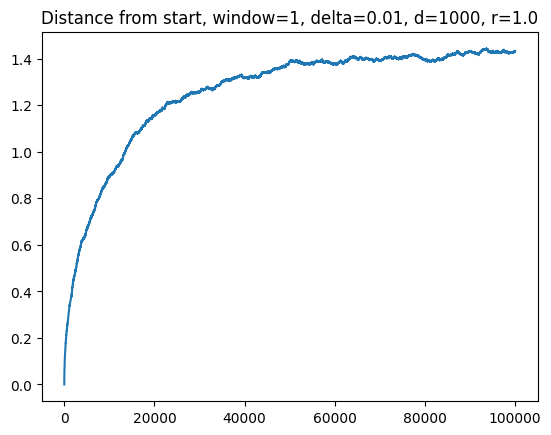

In [29]:
norms = plot_distance_from_start(100_000, delta=0.01, d=1000, r=1.)

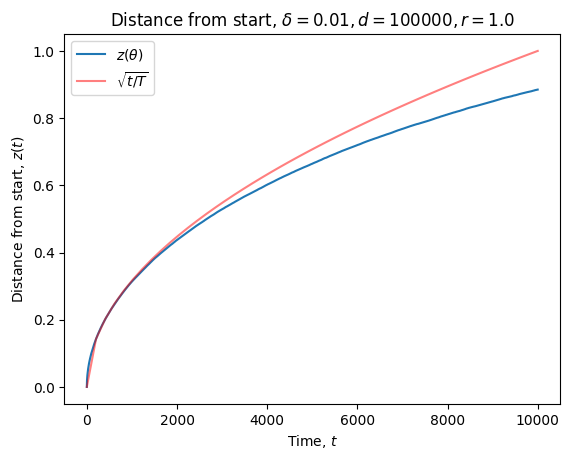

In [55]:
plot_distance_from_start(10_000, delta=0.01, d=100000, r=1.)

times = np.linspace(0, 10_000)
ys = np.sqrt(times / 10_000)
plt.plot(times, ys, color='red', alpha=0.5, label=r"$\sqrt{t/T}$")
plt.xlabel(r"Time, $t$")
plt.ylabel(r"Distance from start, $z(t)$")

plt.legend()

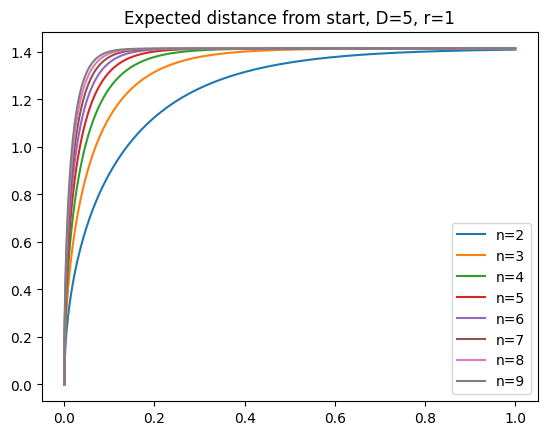

In [56]:
# \cos(\theta)= \exp(-D(n-1)t/R^2)

def plot_expected_motion(T=1000, n=2, D=1., r=1.):
    times = np.linspace(0, 1, T)
    cos_sims = np.exp(-D * (n-1) * times / (r ** 2))
    # thetas = np.arccos(cos_sims)
    # xs = r * np.cos(thetas)
    # ys = r * np.sin(thetas)

    # distances = np.sqrt((xs - xs[0])**2 + (ys - ys[0])**2)
    distances = 2 * r * np.sqrt((1- cos_sims) / 2)

    # plt.plot(times, cos_sims, label=f"n={n}")
    plt.plot(times, distances, label=f"n={n}")

plt.title(f"Expected distance from start, D=5, r=1")
for n in range(2, 10):
    plot_expected_motion(n=n, D=5)

plt.legend()